In [3]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [4]:
from typing import Set, List, Iterable
import collections
import itertools
from numpy.random import default_rng
import numpy as np
import random
import sys
from pathlib import Path
import re
import pandas as pd
from pympler.asizeof import asizeof
from humanize.filesize import naturalsize
import seaborn as sns

%matplotlib inline

<IPython.core.display.Javascript object>

In [5]:
from scipy.integrate import quad as integrate


def _false_positive_probability(threshold, b, r):
    _probability = lambda s: 1 - (1 - s ** float(r)) ** float(b)
    a, err = integrate(_probability, 0.0, threshold)
    return a


def _false_negative_probability(threshold, b, r):
    _probability = lambda s: 1 - (1 - (1 - s ** float(r)) ** float(b))
    a, err = integrate(_probability, threshold, 1.0)
    return a


def _optimal_param(threshold, num_perm, false_positive_weight, false_negative_weight):
    """
    Compute the optimal `MinHashLSH` parameter that minimizes the weighted sum
    of probabilities of false positive and false negative.
    """
    min_error = float("inf")
    opt = (0, 0)
    for b in range(1, num_perm + 1):
        max_r = int(num_perm / b)
        for r in range(1, max_r + 1):
            fp = _false_positive_probability(threshold, b, r)
            fn = _false_negative_probability(threshold, b, r)
            error = fp * false_positive_weight + fn * false_negative_weight
            if error < min_error:
                min_error = error
                opt = (b, r)
    return opt


def _optimal_param2(threshold, num_perm, false_positive_weight, false_negative_weight):
    """
    Compute the optimal `MinHashLSH` parameter that minimizes the weighted sum
    of probabilities of false positive and false negative.
    """
    min_error = float("inf")
    opt = (0, 0)
    for b in range(2, num_perm + 1):
        r = num_perm // b
        fp = _false_positive_probability(threshold, b, r)
        if fp * false_positive_weight >= min_error:
            continue
        fn = _false_negative_probability(threshold, b, r)
        error = fp * false_positive_weight + fn * false_negative_weight
        if error < min_error:
            min_error = error
            opt = (b, r)
    return *opt, min_error

<IPython.core.display.Javascript object>

In [64]:
import matplotlib.pyplot as plt
from matplotlib import cm

num_perm = 64
threshold = 0.5
rows = np.arange(1, num_perm + 1, 1)
bands = np.arange(1, num_perm + 1, 1)
vec_false_negative_probability = np.vectorize(_false_negative_probability)
vec_false_positive_probability = np.vectorize(_false_positive_probability)
bands, rows = np.meshgrid(bands, rows)
proba_false_negative = np.array(vec_false_negative_probability(threshold, bands, rows))
proba_false_positive = np.array(vec_false_positive_probability(threshold, bands, rows))

<IPython.core.display.Javascript object>

In [67]:
bands_2d = np.arange(1, num_perm + 1, 1)

proba_false_negative_2d = np.array(
    vec_false_negative_probability(threshold, bands_2d, num_perm // bands_2d)
)
proba_false_positive_2d = np.array(
    vec_false_positive_probability(threshold, bands_2d, num_perm // bands_2d)
)

<IPython.core.display.Javascript object>

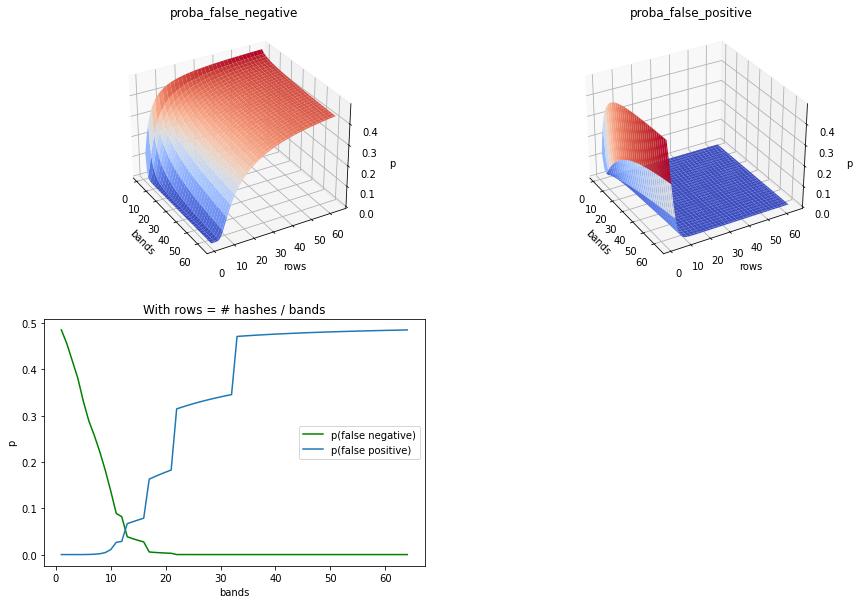

<IPython.core.display.Javascript object>

In [68]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 2, 1, projection="3d", azim=-30, elev=30)
ax.plot_surface(
    bands,
    rows,
    proba_false_negative,
    cmap=cm.coolwarm,
    shade=False,
)
ax.set_title("proba_false_negative")
ax.set_xlabel("bands")
ax.set_ylabel("rows")
ax.set_zlabel("p")

ax = fig.add_subplot(2, 2, 2, projection="3d", azim=-30, elev=30)
ax.plot_surface(
    bands,
    rows,
    proba_false_positive,
    cmap=cm.coolwarm,
)
ax.set_title("proba_false_positive")
ax.set_xlabel("bands")
ax.set_ylabel("rows")
ax.set_zlabel("p")

ax = fig.add_subplot(2, 2, 3)
ax.plot(bands_2d, proba_false_negative_2d, color="g", label="p(false negative)")
ax.plot(bands_2d, proba_false_positive_2d, label="p(false positive)")
ax.set_title("With rows = # hashes / bands")
ax.set_xlabel("bands")
ax.set_ylabel("p")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
None

In [104]:
import warnings


def params_given_false_negative_proba(threshold, num_perm, max_false_negative_proba):
    for b in range(1, num_perm + 1):
        r = num_perm // b
        fn = _false_negative_probability(threshold, b, r)
        if fn <= max_false_negative_proba:
            return b, r
    warnings.warn(
        "Unable to reach max_false_negative_proba. Taking maximum number of bands to maximize the number of candidates returned"
    )
    return num_perm, 1


def params_given_false_positive_proba(threshold, num_perm, max_false_positive_proba):
    for b in range(num_perm, 0, -1):
        r = num_perm // b
        fp = _false_positive_probability(threshold, b, r)
        if fp <= max_false_positive_proba:
            return b, r
    warnings.warn(
        "Unable to reach max_false_positive_proba. Taking minimum number of bands to minimize false positives"
    )
    return 1, num_perm


def num_hashes_and_params_for_given_threshold(
    threshold, max_false_negative_proba, max_false_positive_proba
):
    num_perm = 2
    b, r = params_given_false_negative_proba(
        threshold, num_perm, max_false_negative_proba
    )
    fp = _false_positive_probability(threshold, b, r)
    while fp > max_false_positive_proba:
        num_perm *= 2
        print(num_perm)
        b, r = params_given_false_negative_proba(
            threshold, num_perm, max_false_negative_proba
        )
        fp = _false_positive_probability(threshold, b, r)
        if num_perm >= 16384:
            warnings.warn("Unable to reach error thresholds. Taking the best value.")
            break

    return num_perm, b, r


params_given_false_negative_proba(threshold, num_perm, 0.1)

(11, 5)

<IPython.core.display.Javascript object>

In [105]:
params_given_false_negative_proba(threshold, num_perm, 0.1)

(11, 5)

<IPython.core.display.Javascript object>

In [106]:
params_given_false_positive_proba(0.99, 5, 0.1)

/tmp/ipykernel_122007/273137227.py:22: UserWarning: Unable to reach max_false_positive_proba. Taking minimum number of bands to minimize false positives
  warnings.warn(


(1, 5)

<IPython.core.display.Javascript object>

In [114]:
n_hashes, b, r = num_hashes_and_params_for_given_threshold(0.6, 0.05, 0.05)
n_hashes, b, r

4
8
16
32
64
128


(128, 18, 7)

<IPython.core.display.Javascript object>

In [113]:
_false_negative_probability(0.6, b, r), _false_positive_probability(0.6, b, r)

(0.04967856443282645, 0.03344712666003548)

<IPython.core.display.Javascript object>